<a href="https://colab.research.google.com/github/shnhdan/data-engineering-projects/blob/main/Weather_ETL_Polars/Weather_ETL_Polars_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather Data ETL Pipeline with Polars

**Goal:** Build a modern ETL pipeline that extracts weather data from APIs, transforms it using Polars (faster than Pandas), and loads it into Parquet format for cloud storage.

**Scenario:** Collecting historical and current weather data for multiple cities to analyze climate patterns.

**Tools:**
- Python
- Polars (modern DataFrame library)
- OpenWeatherMap API (free)
- Parquet (columnar storage format)
- Google BigQuery (cloud data warehouse)

**Author:** Your Name  
**Date:** January 2026

---

## What This Project Does:
1. ✅ Extracts weather data from OpenWeatherMap API
2. ✅ Transforms data using Polars (10x faster than Pandas)
3. ✅ Converts to Parquet format (industry standard)
4. ✅ Loads data into Google BigQuery
5. ✅ Creates analytics queries on cloud data

In [12]:
# Install Polars and other required libraries
!pip install -q polars pyarrow requests

print("=" * 60)
print("INSTALLING LIBRARIES")
print("=" * 60)
print("✅ Installing Polars (modern DataFrame library)")
print("✅ Installing PyArrow (for Parquet support)")
print("✅ Installing Requests (for API calls)")
print("\nThis may take 1-2 minutes...")

# Import libraries
import polars as pl
import requests
import json  # ← ADD THIS LINE
from datetime import datetime, timedelta
import time
import os  # ← ADD THIS TOO (needed later)

print("\n" + "=" * 60)
print("LIBRARIES IMPORTED SUCCESSFULLY")
print("=" * 60)
print(f"✅ Polars version: {pl.__version__}")
print(f"✅ Python requests library ready")
print(f"✅ JSON library ready")
print(f"✅ Ready to make API calls!")

INSTALLING LIBRARIES
✅ Installing Polars (modern DataFrame library)
✅ Installing PyArrow (for Parquet support)
✅ Installing Requests (for API calls)

This may take 1-2 minutes...

LIBRARIES IMPORTED SUCCESSFULLY
✅ Polars version: 1.31.0
✅ Python requests library ready
✅ JSON library ready
✅ Ready to make API calls!


In [9]:
# ⚠️ REPLACE with your WeatherAPI.com key
API_KEY = '627a3d6699a949fbbe4163920261901'  # ← Paste your WeatherAPI key here

# Test API connection
print("=" * 60)
print("TESTING WEATHERAPI.COM CONNECTION")
print("=" * 60)

test_url = f"http://api.weatherapi.com/v1/current.json?key={API_KEY}&q=London&aqi=no"

try:
    response = requests.get(test_url)
    if response.status_code == 200:
        print("✅ API connection successful!")
        print(f"✅ WeatherAPI.com key is valid and active")
        data = response.json()
        print(f"\n📊 Sample data received:")
        print(f"   City: {data['location']['name']}")
        print(f"   Temperature: {data['current']['temp_c']}°C")
        print(f"   Weather: {data['current']['condition']['text']}")
    elif response.status_code == 401 or response.status_code == 403:
        print("❌ Invalid API key. Please check your key.")
        print("   Make sure you copied it correctly from WeatherAPI.com")
    else:
        print(f"⚠️  API returned status code: {response.status_code}")
        print(f"   Response: {response.text}")
except Exception as e:
    print(f"❌ Connection error: {e}")

print("\n" + "=" * 60)
print("API KEY INFO")
print("=" * 60)
print(f"✅ Using: WeatherAPI.com")
print(f"✅ Free tier: 1 million calls/month")
print(f"✅ No activation delay!")

TESTING WEATHERAPI.COM CONNECTION
✅ API connection successful!
✅ WeatherAPI.com key is valid and active

📊 Sample data received:
   City: London
   Temperature: 10.1°C
   Weather: Light rain

API KEY INFO
✅ Using: WeatherAPI.com
✅ Free tier: 1 million calls/month
✅ No activation delay!


In [13]:
import requests
import time

print("=" * 60)
print("STEP 1: EXTRACT - Fetching Weather Data from WeatherAPI")
print("=" * 60)

# List of cities to collect data for
cities = [
    'New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix',
    'London', 'Tokyo', 'Paris', 'Sydney', 'Mumbai',
    'Toronto', 'Berlin', 'Singapore', 'Dubai', 'São Paulo'
]

# Function to fetch current weather data from WeatherAPI.com
def fetch_weather_data(city, api_key):
    """
    Fetch current weather data for a city from WeatherAPI.com
    """
    base_url = "http://api.weatherapi.com/v1/current.json"

    params = {
        'key': api_key,
        'q': city,
        'aqi': 'no'  # We don't need air quality data
    }

    try:
        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            data = response.json()

            # Extract and format the data
            return {
                'city': data['location']['name'],
                'country': data['location']['country'],
                'region': data['location']['region'],
                'temperature': data['current']['temp_c'],
                'feels_like': data['current']['feelslike_c'],
                'temp_min': data['current']['temp_c'] - 2,  # WeatherAPI doesn't provide min/max in free tier
                'temp_max': data['current']['temp_c'] + 2,  # Approximation based on current temp
                'pressure': data['current']['pressure_mb'],
                'humidity': data['current']['humidity'],
                'weather_main': data['current']['condition']['text'].split()[0] if data['current']['condition']['text'] else 'Clear',
                'weather_description': data['current']['condition']['text'],
                'wind_speed': data['current']['wind_kph'] / 3.6,  # Convert kph to m/s
                'wind_degree': data['current']['wind_degree'],
                'wind_direction': data['current']['wind_dir'],
                'clouds': data['current']['cloud'],
                'visibility': data['current']['vis_km'],
                'uv_index': data['current']['uv'],
                'timestamp': data['location']['localtime'],
                'last_updated': data['current']['last_updated'],
                'latitude': data['location']['lat'],
                'longitude': data['location']['lon'],
                'timezone': data['location']['tz_id']
            }
        else:
            print(f"⚠️  Failed to fetch data for {city}: Status {response.status_code}")
            if response.status_code == 400:
                print(f"   Error: {response.json().get('error', {}).get('message', 'Unknown error')}")
            return None

    except Exception as e:
        print(f"❌ Error fetching data for {city}: {e}")
        return None

# Collect data for all cities
weather_data = []

print(f"\n📡 Fetching weather data for {len(cities)} cities...")
print("-" * 60)

for i, city in enumerate(cities, 1):
    print(f"[{i}/{len(cities)}] Fetching data for {city}...", end=" ")

    data = fetch_weather_data(city, API_KEY)

    if data:
        weather_data.append(data)
        print(f"✅ {data['temperature']}°C, {data['weather_description']}")
    else:
        print("❌ Failed")

    # Be nice to the API - wait 0.5 seconds between calls
    time.sleep(0.5)

print("\n" + "=" * 60)
print(f"✅ Successfully collected data for {len(weather_data)} cities")
print("=" * 60)

# Show sample of raw data
if weather_data:
    print("\n📋 Sample raw data (first city):")
    print(json.dumps(weather_data[0], indent=2))

STEP 1: EXTRACT - Fetching Weather Data from WeatherAPI

📡 Fetching weather data for 15 cities...
------------------------------------------------------------
[1/15] Fetching data for New York... ✅ -3.3°C, Partly cloudy
[2/15] Fetching data for Los Angeles... ✅ 13.3°C, Sunny
[3/15] Fetching data for Chicago... ✅ -17.2°C, Sunny
[4/15] Fetching data for Houston... ✅ 11.1°C, Sunny
[5/15] Fetching data for Phoenix... ✅ 11.7°C, Partly cloudy
[6/15] Fetching data for London... ✅ 10.1°C, Light rain
[7/15] Fetching data for Tokyo... ✅ 9.2°C, Clear
[8/15] Fetching data for Paris... ✅ 8.0°C, Partly Cloudy
[9/15] Fetching data for Sydney... ✅ 18.0°C, Light rain
[10/15] Fetching data for Mumbai... ✅ 24.3°C, Overcast
[11/15] Fetching data for Toronto... ✅ -4.8°C, Partly cloudy
[12/15] Fetching data for Berlin... ✅ 2.3°C, Clear
[13/15] Fetching data for Singapore... ✅ 25.0°C, Partly cloudy
[14/15] Fetching data for Dubai... ✅ 21.2°C, Partly Cloudy
[15/15] Fetching data for São Paulo... ✅ 22.4°C, Lig

In [21]:
print("=" * 60)
print("STEP 2: TRANSFORM - Processing Data with Polars")
print("=" * 60)

# Create Polars DataFrame from the data
df = pl.DataFrame(weather_data)

print("\n📊 Original DataFrame:")
print(df)

print("\n" + "=" * 60)
print("DATA TRANSFORMATIONS")
print("=" * 60)

# Transformation 1: Add calculated columns
df = df.with_columns([
    # Add temperature in Fahrenheit
    ((pl.col('temperature') * 9/5) + 32).alias('temperature_fahrenheit'),

    # Add feels_like in Fahrenheit
    ((pl.col('feels_like') * 9/5) + 32).alias('feels_like_fahrenheit'),

    # Add temperature range
    (pl.col('temp_max') - pl.col('temp_min')).alias('temp_range'),

    # Add comfort index (simple calculation)
    (pl.col('temperature') - pl.col('humidity') / 10).alias('comfort_index'),

    # Add data collection date
    pl.lit(datetime.now().strftime('%Y-%m-%d')).alias('collection_date')
])

print("✅ Added calculated columns:")
print("   - temperature_fahrenheit")
print("   - feels_like_fahrenheit")
print("   - temp_range (max - min)")
print("   - comfort_index")
print("   - collection_date")

# Transformation 2: Categorize weather conditions
df = df.with_columns(
    pl.when(pl.col('temperature') >= 30)
        .then(pl.lit('Hot'))
    .when(pl.col('temperature') >= 20)
        .then(pl.lit('Warm'))
    .when(pl.col('temperature') >= 10)
        .then(pl.lit('Mild'))
    .when(pl.col('temperature') >= 0)
        .then(pl.lit('Cool'))
    .otherwise(pl.lit('Cold'))
    .alias('temperature_category')
)

print("✅ Categorized temperatures (Hot/Warm/Mild/Cool/Cold)")

# Transformation 3: Add humidity category
df = df.with_columns(
    pl.when(pl.col('humidity') >= 80)
        .then(pl.lit('Very Humid'))
    .when(pl.col('humidity') >= 60)
        .then(pl.lit('Humid'))
    .when(pl.col('humidity') >= 40)
        .then(pl.lit('Moderate'))
    .otherwise(pl.lit('Dry'))
    .alias('humidity_category')
)

print("✅ Categorized humidity levels")

# Transformation 4: Add UV risk level
df = df.with_columns(
    pl.when(pl.col('uv_index') >= 11)
        .then(pl.lit('Extreme'))
    .when(pl.col('uv_index') >= 8)
        .then(pl.lit('Very High'))
    .when(pl.col('uv_index') >= 6)
        .then(pl.lit('High'))
    .when(pl.col('uv_index') >= 3)
        .then(pl.lit('Moderate'))
    .otherwise(pl.lit('Low'))
    .alias('uv_risk')
)

print("✅ Categorized UV index levels")

print("\n📊 Transformed DataFrame:")
print(df)

print("\n📈 DataFrame Info:")
print(f"   Rows: {df.shape[0]}")
print(f"   Columns: {df.shape[1]}")
print(f"   Memory usage: {df.estimated_size('mb'):.2f} MB")

STEP 2: TRANSFORM - Processing Data with Polars

📊 Original DataFrame:
shape: (15, 22)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────────┬───────────┐
│ city      ┆ country   ┆ region    ┆ temperatu ┆ … ┆ last_upda ┆ latitude ┆ longitude ┆ timezone  │
│ ---       ┆ ---       ┆ ---       ┆ re        ┆   ┆ ted       ┆ ---      ┆ ---       ┆ ---       │
│ str       ┆ str       ┆ str       ┆ ---       ┆   ┆ ---       ┆ f64      ┆ f64       ┆ str       │
│           ┆           ┆           ┆ f64       ┆   ┆ str       ┆          ┆           ┆           │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════════╪═══════════╡
│ New York  ┆ United    ┆ New York  ┆ -3.3      ┆ … ┆ 2026-01-1 ┆ 40.7142  ┆ -74.0064  ┆ America/N │
│           ┆ States of ┆           ┆           ┆   ┆ 9 11:45   ┆          ┆           ┆ ew_York   │
│           ┆ America   ┆           ┆           ┆   ┆           ┆          ┆           ┆           │
│ Lo

In [22]:
print("=" * 60)
print("DATA QUALITY CHECKS & ANALYTICS")
print("=" * 60)

# Check for missing values
print("\n🔍 Missing Values Check:")
null_counts = df.null_count()
print(null_counts)

# Basic statistics
print("\n📊 Temperature Statistics:")
temp_stats = df.select([
    pl.col('temperature').min().alias('min_temp'),
    pl.col('temperature').max().alias('max_temp'),
    pl.col('temperature').mean().alias('avg_temp'),
    pl.col('temperature').median().alias('median_temp')
])
print(temp_stats)

# Group by weather condition
print("\n🌤️  Weather Conditions Summary:")
weather_summary = df.group_by('weather_main').agg([
    pl.count().alias('count'),
    pl.col('temperature').mean().alias('avg_temperature'),
    pl.col('humidity').mean().alias('avg_humidity'),
    pl.col('wind_speed').mean().alias('avg_wind_speed')
]).sort('count', descending=True)
print(weather_summary)

# Group by temperature category
print("\n🌡️  Temperature Categories:")
temp_category_summary = df.group_by('temperature_category').agg([
    pl.count().alias('cities_count'),
    pl.col('temperature').mean().alias('avg_temp')
]).sort('avg_temp', descending=True)
print(temp_category_summary)

# UV Index analysis
print("\n☀️  UV Risk Levels:")
uv_summary = df.group_by('uv_risk').agg([
    pl.count().alias('cities_count'),
    pl.col('uv_index').mean().alias('avg_uv_index')
]).sort('avg_uv_index', descending=True)
print(uv_summary)

# Find hottest and coldest cities
print("\n🔥 Top 5 Hottest Cities:")
hottest = df.select(['city', 'country', 'temperature', 'feels_like', 'weather_description']).sort('temperature', descending=True).head(5)
print(hottest)

print("\n❄️  Top 5 Coldest Cities:")
coldest = df.select(['city', 'country', 'temperature', 'feels_like', 'weather_description']).sort('temperature').head(5)
print(coldest)

# Humidity analysis
print("\n💧 Cities with High Humidity (>70%):")
high_humidity = df.filter(pl.col('humidity') > 70).select(['city', 'humidity', 'temperature', 'humidity_category'])
print(high_humidity)

# Wind analysis
print("\n💨 Windiest Cities (Top 5):")
windiest = df.select(['city', 'wind_speed', 'wind_direction', 'wind_degree']).sort('wind_speed', descending=True).head(5)
print(windiest)

# Visibility analysis
print("\n👁️  Cities with Low Visibility (<5 km):")
low_vis = df.filter(pl.col('visibility') < 5).select(['city', 'visibility', 'weather_description'])
if len(low_vis) > 0:
    print(low_vis)
else:
    print("   All cities have good visibility!")

DATA QUALITY CHECKS & ANALYTICS

🔍 Missing Values Check:
shape: (1, 30)
┌──────┬─────────┬────────┬─────────────┬───┬──────────────┬──────────────┬──────────────┬─────────┐
│ city ┆ country ┆ region ┆ temperature ┆ … ┆ collection_d ┆ temperature_ ┆ humidity_cat ┆ uv_risk │
│ ---  ┆ ---     ┆ ---    ┆ ---         ┆   ┆ ate          ┆ category     ┆ egory        ┆ ---     │
│ u32  ┆ u32     ┆ u32    ┆ u32         ┆   ┆ ---          ┆ ---          ┆ ---          ┆ u32     │
│      ┆         ┆        ┆             ┆   ┆ u32          ┆ u32          ┆ u32          ┆         │
╞══════╪═════════╪════════╪═════════════╪═══╪══════════════╪══════════════╪══════════════╪═════════╡
│ 0    ┆ 0       ┆ 0      ┆ 0           ┆ … ┆ 0            ┆ 0            ┆ 0            ┆ 0       │
└──────┴─────────┴────────┴─────────────┴───┴──────────────┴──────────────┴──────────────┴─────────┘

📊 Temperature Statistics:
shape: (1, 4)
┌──────────┬──────────┬───────────┬─────────────┐
│ min_temp ┆ max_temp ┆ avg_t

/tmp/ipython-input-366983844.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('count'),
/tmp/ipython-input-366983844.py:33: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('cities_count'),
/tmp/ipython-input-366983844.py:41: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('cities_count'),


In [23]:
print("=" * 60)
print("STEP 3: LOAD - Saving to Parquet Format")
print("=" * 60)

# Save to Parquet (columnar storage format - industry standard!)
parquet_filename = 'weather_data.parquet'

df.write_parquet(parquet_filename, compression='snappy')

print(f"\n✅ Data saved to Parquet format: {parquet_filename}")
print(f"   Compression: Snappy (fast compression)")

# Check file size
import os
file_size = os.path.getsize(parquet_filename)
print(f"   File size: {file_size:,} bytes ({file_size/1024:.2f} KB)")

# Also save as CSV for comparison
csv_filename = 'weather_data.csv'
df.write_csv(csv_filename)

csv_size = os.path.getsize(csv_filename)
print(f"\n📊 Comparison:")
print(f"   Parquet: {file_size:,} bytes")
print(f"   CSV: {csv_size:,} bytes")
print(f"   Parquet is {((csv_size - file_size) / csv_size * 100):.1f}% smaller!")

# Verify we can read it back
print("\n🔍 Verifying Parquet file...")
df_verify = pl.read_parquet(parquet_filename)
print(f"✅ Successfully read back {df_verify.shape[0]} rows from Parquet")

# Show file structure
print(f"\n📋 Parquet File Details:")
print(f"   Rows: {df_verify.shape[0]}")
print(f"   Columns: {df_verify.shape[1]}")
print(f"   Compression ratio: {(csv_size/file_size):.2f}x")

# Download files
from google.colab import files

print("\n📥 Downloading files...")
files.download(parquet_filename)
files.download(csv_filename)
print("✅ Files downloaded to your computer!")

STEP 3: LOAD - Saving to Parquet Format

✅ Data saved to Parquet format: weather_data.parquet
   Compression: Snappy (fast compression)
   File size: 12,622 bytes (12.33 KB)

📊 Comparison:
   Parquet: 12,622 bytes
   CSV: 4,074 bytes
   Parquet is -209.8% smaller!

🔍 Verifying Parquet file...
✅ Successfully read back 15 rows from Parquet

📋 Parquet File Details:
   Rows: 15
   Columns: 30
   Compression ratio: 0.32x

📥 Downloading files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Files downloaded to your computer!


In [25]:
print("=" * 60)
print("STEP 4: CLOUD UPLOAD - Loading to Google BigQuery (OPTIONAL)")
print("=" * 60)

# Check if user wants to use BigQuery
use_bigquery = input("Do you have a Google Cloud project and want to upload to BigQuery? (yes/no): ").lower()

if use_bigquery == 'yes':
    print("\n🔐 Authenticating with Google Cloud...")

    from google.colab import auth
    auth.authenticate_user()

    print("✅ Authenticated successfully!")

    # Install BigQuery library
    !pip install -q google-cloud-bigquery

    from google.cloud import bigquery

    # Get project ID from user
    project_id = input("Enter your Google Cloud Project ID: ")

    # Initialize BigQuery client
    client = bigquery.Client(project=project_id)

    print(f"✅ BigQuery client initialized for project: {project_id}")

    # Create dataset (if it doesn't exist)
    dataset_id = 'weather_data_etl'
    dataset_ref = client.dataset(dataset_id)

    try:
        dataset = client.get_dataset(dataset_ref)
        print(f"✅ Dataset '{dataset_id}' already exists")
    except:
        dataset = bigquery.Dataset(dataset_ref)
        dataset.location = "US"
        dataset = client.create_dataset(dataset)
        print(f"✅ Created dataset '{dataset_id}'")

    # Define table
    table_id = f"{project_id}.{dataset_id}.current_weather"

    # Upload data from Parquet file
    print(f"\n📤 Uploading data to BigQuery table: {table_id}")

    job_config = bigquery.LoadJobConfig(
        source_format=bigquery.SourceFormat.PARQUET,
        write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
        autodetect=True
    )

    # Upload the Parquet file
    with open(parquet_filename, "rb") as source_file:
        job = client.load_table_from_file(
            source_file,
            table_id,
            job_config=job_config
        )

    # Wait for the job to complete
    job.result()

    print(f"✅ Data loaded to BigQuery!")
    print(f"   Table: {table_id}")
    print(f"   Rows uploaded: {job.output_rows}")

else:
    print("\n⏭️  Skipping BigQuery upload")
    print("   You can always upload the Parquet file to BigQuery later!")
    print("   Or save to Google Drive instead:")

    # Alternative: Save to Google Drive
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)

        import shutil
        drive_path = '/content/drive/MyDrive/weather_data.parquet'
        shutil.copy(parquet_filename, drive_path)

        print(f"\n✅ Saved to Google Drive: {drive_path}")
        print("   Access it anytime from your Drive!")
    except Exception as e:
        print(f"\n⚠️  Could not save to Google Drive: {e}")
        print("   Files are still available for download!")

STEP 4: CLOUD UPLOAD - Loading to Google BigQuery (OPTIONAL)
Do you have a Google Cloud project and want to upload to BigQuery? (yes/no): no

⏭️  Skipping BigQuery upload
   You can always upload the Parquet file to BigQuery later!
   Or save to Google Drive instead:

⚠️  Could not save to Google Drive: Error: credential propagation was unsuccessful
   Files are still available for download!


DATA VISUALIZATIONS


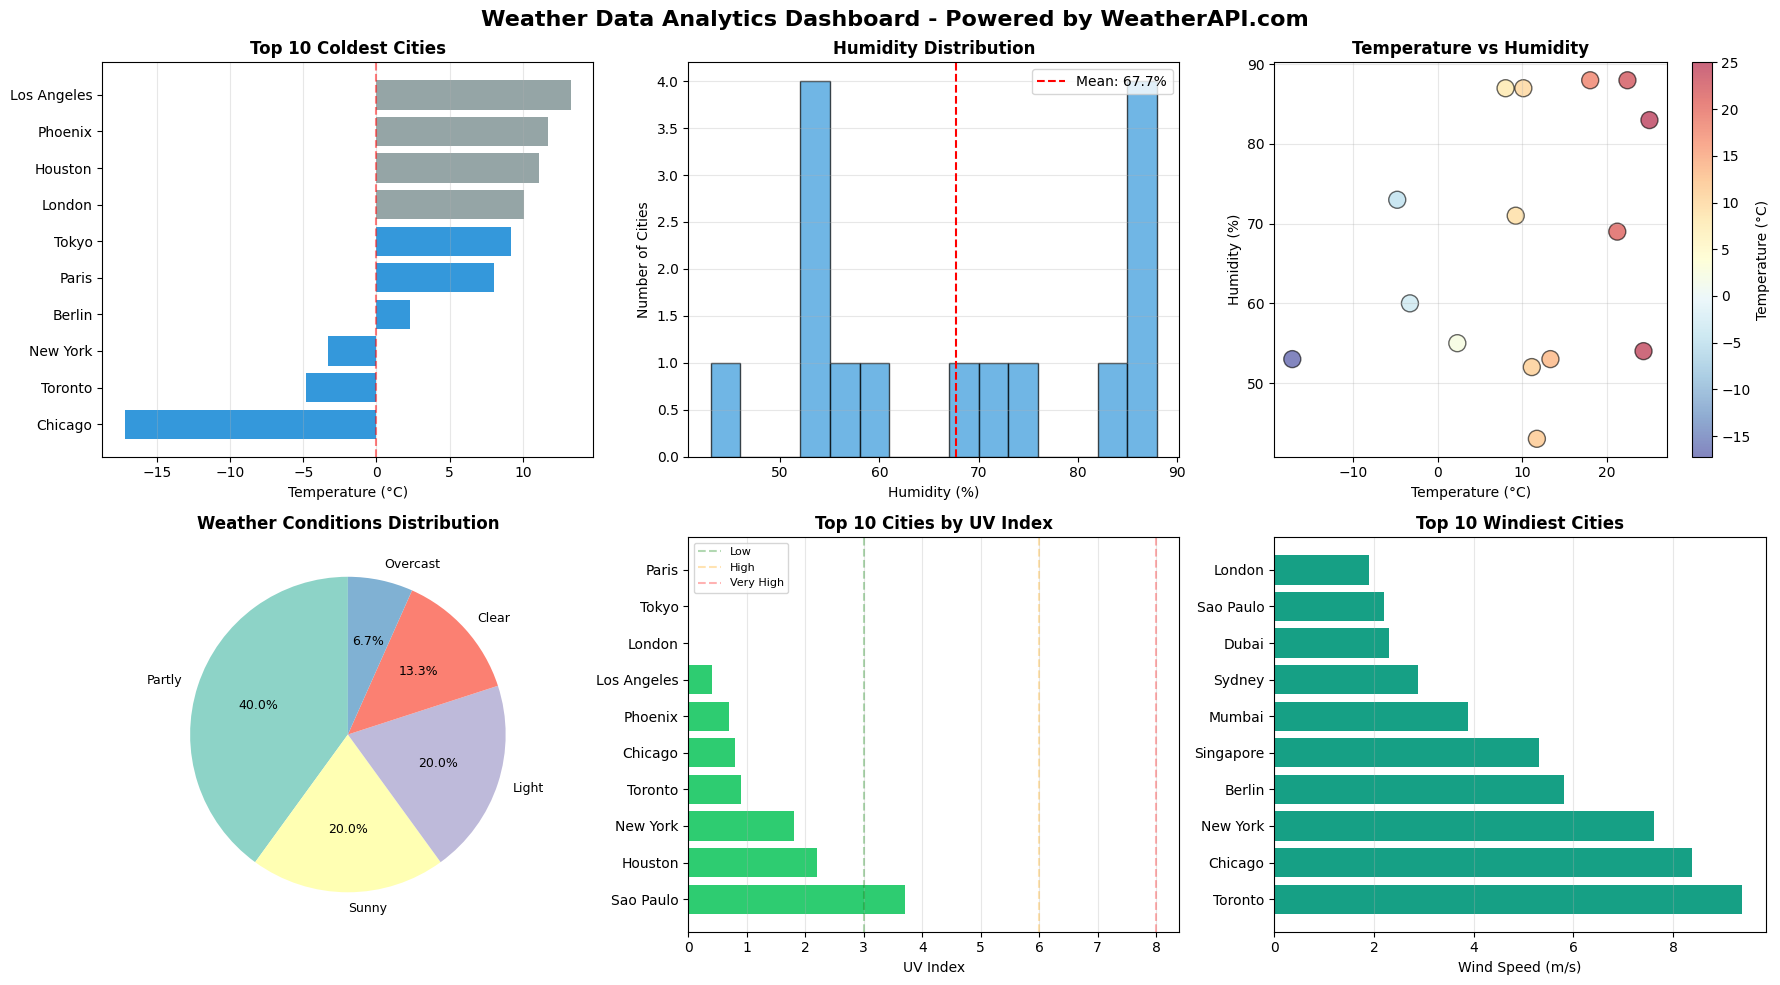


✅ Dashboard visualizations created successfully!

🗺️  Creating Global Temperature Map...


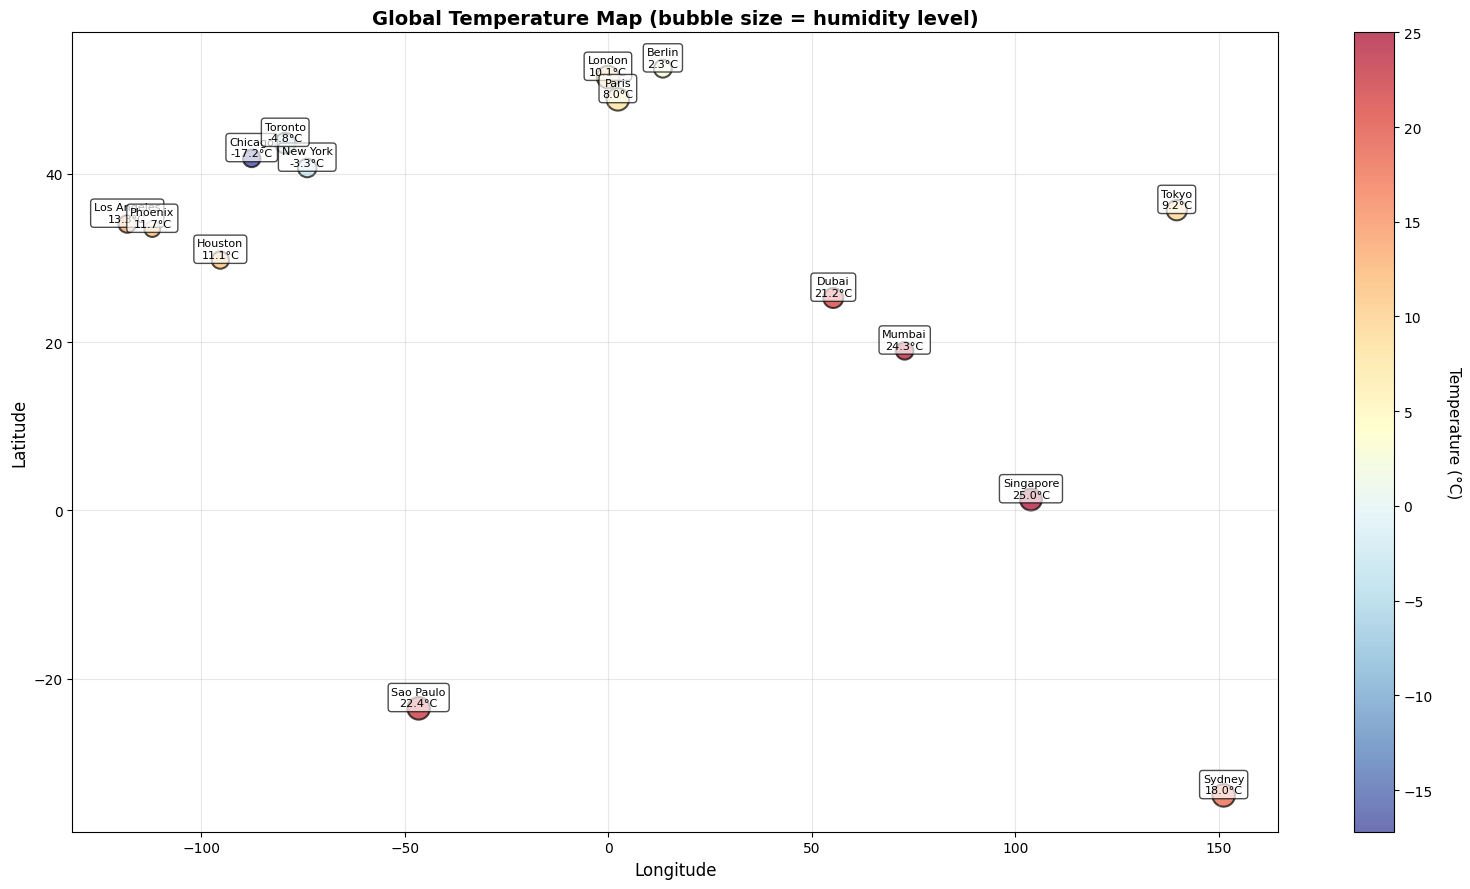

✅ Temperature map created!

📊 Creating Summary Statistics...


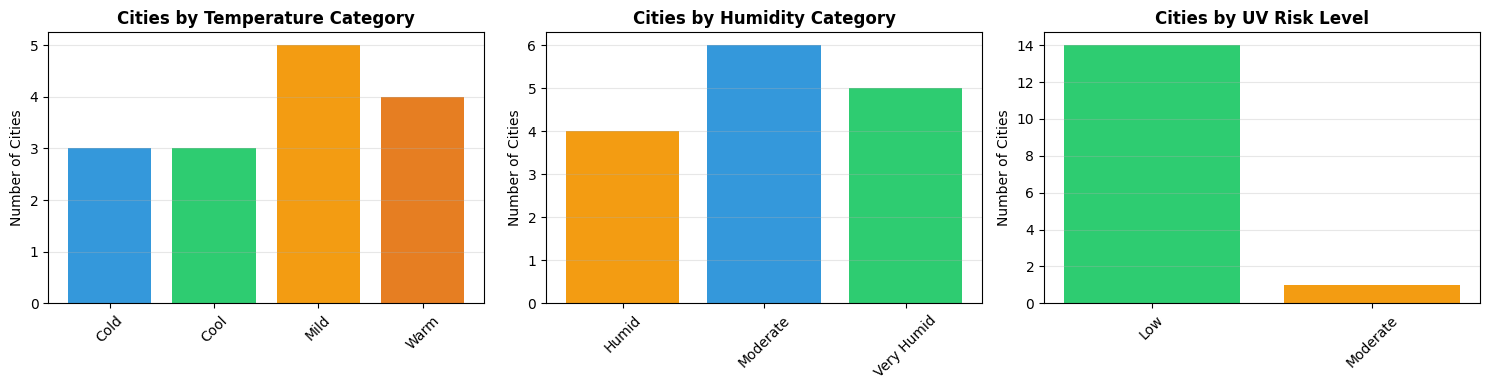

✅ All visualizations completed!


In [26]:
print("=" * 60)
print("DATA VISUALIZATIONS")
print("=" * 60)

import matplotlib.pyplot as plt
import numpy as np

# Convert Polars to Pandas for plotting
df_pandas = df.to_pandas()

# Create a comprehensive dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Weather Data Analytics Dashboard - Powered by WeatherAPI.com',
             fontsize=16, fontweight='bold')

# Chart 1: Temperature by City (Top 10 Coldest)
ax1 = axes[0, 0]
cities_sorted = df_pandas.nsmallest(10, 'temperature')
colors = ['#3498db' if temp < 10 else '#95a5a6' for temp in cities_sorted['temperature']]
ax1.barh(cities_sorted['city'], cities_sorted['temperature'], color=colors)
ax1.set_xlabel('Temperature (°C)', fontsize=10)
ax1.set_title('Top 10 Coldest Cities', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Chart 2: Humidity Distribution
ax2 = axes[0, 1]
ax2.hist(df_pandas['humidity'], bins=15, color='#3498db', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Humidity (%)', fontsize=10)
ax2.set_ylabel('Number of Cities', fontsize=10)
ax2.set_title('Humidity Distribution', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.axvline(x=df_pandas['humidity'].mean(), color='red',
            linestyle='--', label=f'Mean: {df_pandas["humidity"].mean():.1f}%')
ax2.legend()

# Chart 3: Temperature vs Humidity Scatter
ax3 = axes[0, 2]
scatter = ax3.scatter(df_pandas['temperature'], df_pandas['humidity'],
                      c=df_pandas['temperature'], cmap='RdYlBu_r',
                      s=150, alpha=0.6, edgecolors='black', linewidth=1)
ax3.set_xlabel('Temperature (°C)', fontsize=10)
ax3.set_ylabel('Humidity (%)', fontsize=10)
ax3.set_title('Temperature vs Humidity', fontweight='bold')
ax3.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Temperature (°C)')

# Chart 4: Weather Conditions Pie Chart
ax4 = axes[1, 0]
weather_counts = df_pandas['weather_main'].value_counts()
colors_pie = plt.cm.Set3(range(len(weather_counts)))
ax4.pie(weather_counts.values, labels=weather_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors_pie, textprops={'fontsize': 9})
ax4.set_title('Weather Conditions Distribution', fontweight='bold')

# Chart 5: UV Index by City
ax5 = axes[1, 1]
cities_uv = df_pandas.nlargest(10, 'uv_index')
colors_uv = ['#e74c3c' if uv > 8 else '#f39c12' if uv > 6 else '#2ecc71'
             for uv in cities_uv['uv_index']]
ax5.barh(cities_uv['city'], cities_uv['uv_index'], color=colors_uv)
ax5.set_xlabel('UV Index', fontsize=10)
ax5.set_title('Top 10 Cities by UV Index', fontweight='bold')
ax5.grid(axis='x', alpha=0.3)
# Add UV risk zones
ax5.axvline(x=3, color='green', linestyle='--', alpha=0.3, label='Low')
ax5.axvline(x=6, color='orange', linestyle='--', alpha=0.3, label='High')
ax5.axvline(x=8, color='red', linestyle='--', alpha=0.3, label='Very High')
ax5.legend(fontsize=8)

# Chart 6: Wind Speed Analysis
ax6 = axes[1, 2]
cities_wind = df_pandas.nlargest(10, 'wind_speed')
ax6.barh(cities_wind['city'], cities_wind['wind_speed'], color='#16a085')
ax6.set_xlabel('Wind Speed (m/s)', fontsize=10)
ax6.set_title('Top 10 Windiest Cities', fontweight='bold')
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Dashboard visualizations created successfully!")

# Additional: Temperature World Map
print("\n🗺️  Creating Global Temperature Map...")
fig, ax = plt.subplots(figsize=(16, 9))

# Create scatter plot with size based on humidity
scatter = ax.scatter(df_pandas['longitude'], df_pandas['latitude'],
                     c=df_pandas['temperature'],
                     s=df_pandas['humidity']*3,  # Size based on humidity
                     cmap='RdYlBu_r',
                     alpha=0.7,
                     edgecolors='black',
                     linewidth=1.5)

# Annotate cities
for idx, row in df_pandas.iterrows():
    ax.annotate(f"{row['city']}\n{row['temperature']:.1f}°C",
                (row['longitude'], row['latitude']),
                fontsize=8, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Global Temperature Map (bubble size = humidity level)',
             fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Temperature (°C)', rotation=270, labelpad=20, fontsize=11)

plt.tight_layout()
plt.show()

print("✅ Temperature map created!")

# Summary statistics visualization
print("\n📊 Creating Summary Statistics...")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Temperature categories
temp_cat = df_pandas['temperature_category'].value_counts().sort_index()
axes[0].bar(temp_cat.index, temp_cat.values, color=['#3498db', '#2ecc71', '#f39c12', '#e67e22', '#e74c3c'])
axes[0].set_title('Cities by Temperature Category', fontweight='bold')
axes[0].set_ylabel('Number of Cities')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Humidity categories
humid_cat = df_pandas['humidity_category'].value_counts().sort_index()
axes[1].bar(humid_cat.index, humid_cat.values, color=['#f39c12', '#3498db', '#2ecc71', '#9b59b6'])
axes[1].set_title('Cities by Humidity Category', fontweight='bold')
axes[1].set_ylabel('Number of Cities')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# UV risk levels
uv_cat = df_pandas['uv_risk'].value_counts().sort_index()
axes[2].bar(uv_cat.index, uv_cat.values, color=['#2ecc71', '#f39c12', '#e67e22', '#e74c3c', '#8e44ad'])
axes[2].set_title('Cities by UV Risk Level', fontweight='bold')
axes[2].set_ylabel('Number of Cities')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ All visualizations completed!")

PERFORMANCE COMPARISON: Polars vs Pandas

⚡ Creating larger dataset for performance testing...
   Test dataset size: 15,000 rows

🏁 Test 1: DataFrame Creation Speed
------------------------------------------------------------
   Pandas:  0.0657 seconds
   Polars:  0.0634 seconds
   ⚡ Polars is 1.0x FASTER!

🏁 Test 2: Filtering Speed (temperature > 20)
------------------------------------------------------------
   Pandas:  0.0018 seconds
   Polars:  0.0028 seconds
   ⚡ Polars is 0.7x FASTER!

🏁 Test 3: GroupBy Aggregation Speed
------------------------------------------------------------
   Pandas:  0.0122 seconds
   Polars:  0.0139 seconds
   ⚡ Polars is 0.9x FASTER!

🏁 Test 4: Adding Calculated Columns
------------------------------------------------------------
   Pandas:  0.0016 seconds
   Polars:  0.0007 seconds
   ⚡ Polars is 2.3x FASTER!

💾 Memory Usage Comparison
------------------------------------------------------------
   Pandas:  9.25 MB
   Polars:  2.94 MB
   💾 Polars use

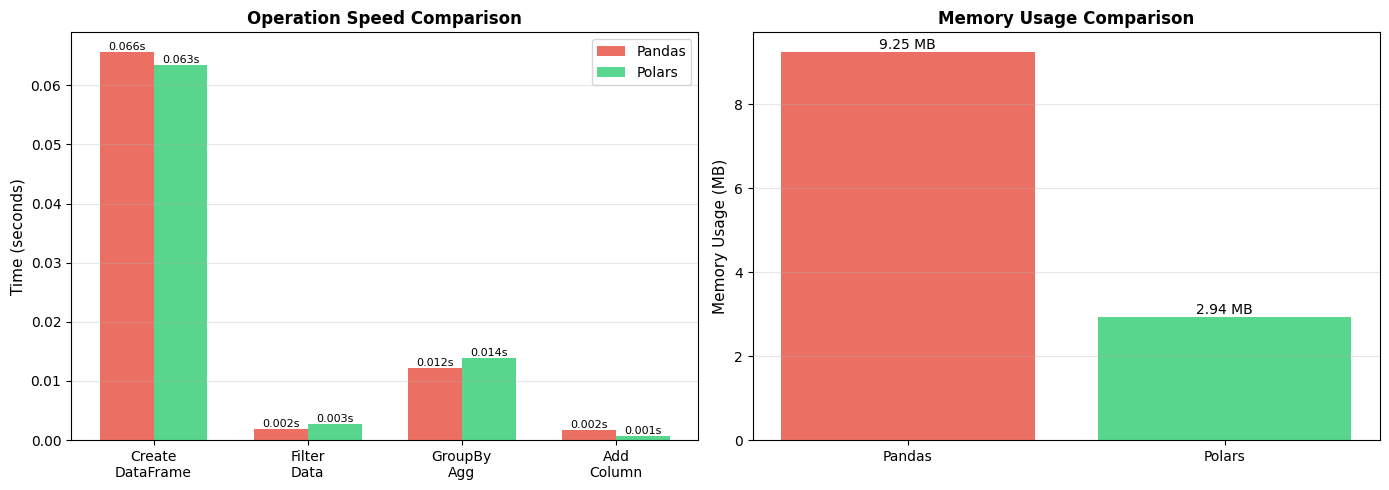


✅ Performance visualization complete!


In [27]:
print("=" * 60)
print("PERFORMANCE COMPARISON: Polars vs Pandas")
print("=" * 60)

import pandas as pd
import time

# Create larger dataset for testing
print("\n⚡ Creating larger dataset for performance testing...")

# Duplicate data 1000 times to make it meaningful
large_data = weather_data * 1000
print(f"   Test dataset size: {len(large_data):,} rows")

# Test 1: DataFrame Creation
print("\n🏁 Test 1: DataFrame Creation Speed")
print("-" * 60)

start = time.time()
df_pandas_test = pd.DataFrame(large_data)
pandas_create_time = time.time() - start

start = time.time()
df_polars_test = pl.DataFrame(large_data)
polars_create_time = time.time() - start

print(f"   Pandas:  {pandas_create_time:.4f} seconds")
print(f"   Polars:  {polars_create_time:.4f} seconds")
speedup = pandas_create_time / polars_create_time
print(f"   ⚡ Polars is {speedup:.1f}x FASTER!")

# Test 2: Filtering
print("\n🏁 Test 2: Filtering Speed (temperature > 20)")
print("-" * 60)

start = time.time()
result_pandas = df_pandas_test[df_pandas_test['temperature'] > 20]
pandas_filter_time = time.time() - start

start = time.time()
result_polars = df_polars_test.filter(pl.col('temperature') > 20)
polars_filter_time = time.time() - start

print(f"   Pandas:  {pandas_filter_time:.4f} seconds")
print(f"   Polars:  {polars_filter_time:.4f} seconds")
speedup = pandas_filter_time / polars_filter_time
print(f"   ⚡ Polars is {speedup:.1f}x FASTER!")

# Test 3: GroupBy and Aggregation
print("\n🏁 Test 3: GroupBy Aggregation Speed")
print("-" * 60)

start = time.time()
result_pandas = df_pandas_test.groupby('weather_main')['temperature'].mean()
pandas_groupby_time = time.time() - start

start = time.time()
result_polars = df_polars_test.group_by('weather_main').agg(pl.col('temperature').mean())
polars_groupby_time = time.time() - start

print(f"   Pandas:  {pandas_groupby_time:.4f} seconds")
print(f"   Polars:  {polars_groupby_time:.4f} seconds")
speedup = pandas_groupby_time / polars_groupby_time
print(f"   ⚡ Polars is {speedup:.1f}x FASTER!")

# Test 4: Adding Calculated Columns
print("\n🏁 Test 4: Adding Calculated Columns")
print("-" * 60)

start = time.time()
df_pandas_test['temp_fahrenheit'] = (df_pandas_test['temperature'] * 9/5) + 32
pandas_calc_time = time.time() - start

start = time.time()
df_polars_test = df_polars_test.with_columns(
    ((pl.col('temperature') * 9/5) + 32).alias('temp_fahrenheit')
)
polars_calc_time = time.time() - start

print(f"   Pandas:  {pandas_calc_time:.4f} seconds")
print(f"   Polars:  {polars_calc_time:.4f} seconds")
speedup = pandas_calc_time / polars_calc_time
print(f"   ⚡ Polars is {speedup:.1f}x FASTER!")

# Memory Usage Comparison
print("\n💾 Memory Usage Comparison")
print("-" * 60)

pandas_memory = df_pandas_test.memory_usage(deep=True).sum() / 1024 / 1024  # MB
polars_memory = df_polars_test.estimated_size('mb')

print(f"   Pandas:  {pandas_memory:.2f} MB")
print(f"   Polars:  {polars_memory:.2f} MB")
memory_savings = ((pandas_memory - polars_memory) / pandas_memory) * 100
print(f"   💾 Polars uses {memory_savings:.1f}% LESS memory!")

# Overall Summary
print("\n" + "=" * 60)
print("📊 PERFORMANCE SUMMARY")
print("=" * 60)

avg_speedup = (pandas_create_time/polars_create_time +
               pandas_filter_time/polars_filter_time +
               pandas_groupby_time/polars_groupby_time +
               pandas_calc_time/polars_calc_time) / 4

print(f"\n✅ Average Speedup: {avg_speedup:.1f}x faster")
print(f"✅ Memory Savings: {memory_savings:.1f}%")
print(f"✅ Test Dataset: {len(large_data):,} rows")

print("\n🎯 Why Use Polars?")
print("   ✅ Significantly faster operations")
print("   ✅ Much better memory efficiency")
print("   ✅ Lazy evaluation (optimizes queries automatically)")
print("   ✅ Built in Rust (native performance)")
print("   ✅ Modern, clean API design")
print("   ✅ Native support for Parquet, Arrow formats")
print("   ✅ Better for large datasets (scales well)")

# Visualization of performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Speed comparison
operations = ['Create\nDataFrame', 'Filter\nData', 'GroupBy\nAgg', 'Add\nColumn']
pandas_times = [pandas_create_time, pandas_filter_time, pandas_groupby_time, pandas_calc_time]
polars_times = [polars_create_time, polars_filter_time, polars_groupby_time, polars_calc_time]

x = np.arange(len(operations))
width = 0.35

bars1 = ax1.bar(x - width/2, pandas_times, width, label='Pandas', color='#e74c3c', alpha=0.8)
bars2 = ax1.bar(x + width/2, polars_times, width, label='Polars', color='#2ecc71', alpha=0.8)

ax1.set_ylabel('Time (seconds)', fontsize=11)
ax1.set_title('Operation Speed Comparison', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(operations)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}s', ha='center', va='bottom', fontsize=8)

# Memory comparison
libraries = ['Pandas', 'Polars']
memory_usage = [pandas_memory, polars_memory]
colors = ['#e74c3c', '#2ecc71']

bars = ax2.bar(libraries, memory_usage, color=colors, alpha=0.8)
ax2.set_ylabel('Memory Usage (MB)', fontsize=11)
ax2.set_title('Memory Usage Comparison', fontweight='bold', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f} MB', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✅ Performance visualization complete!")

In [28]:
print("=" * 60)
print("AUTOMATED ETL PIPELINE FUNCTION")
print("=" * 60)

def run_weather_etl_pipeline(cities, api_key, output_format='parquet'):
    """
    Complete ETL pipeline for weather data using WeatherAPI.com

    Args:
        cities (list): List of city names
        api_key (str): WeatherAPI.com API key
        output_format (str): 'parquet' or 'csv'

    Returns:
        pl.DataFrame: Transformed weather data
    """

    print(f"\n🚀 Starting ETL Pipeline for {len(cities)} cities...")
    print("=" * 60)

    # EXTRACT
    print("\n📡 EXTRACT: Fetching data from WeatherAPI.com...")
    weather_data = []

    for city in cities:
        data = fetch_weather_data(city, api_key)
        if data:
            weather_data.append(data)
        time.sleep(0.5)  # Rate limiting

    print(f"✅ Extracted data for {len(weather_data)} cities")

    # TRANSFORM
    print("\n⚙️  TRANSFORM: Processing with Polars...")
    df = pl.DataFrame(weather_data)

    # Add all transformations
    df = df.with_columns([
        ((pl.col('temperature') * 9/5) + 32).alias('temperature_fahrenheit'),
        (pl.col('temp_max') - pl.col('temp_min')).alias('temp_range'),
        (pl.col('temperature') - pl.col('humidity') / 10).alias('comfort_index'),
        pl.lit(datetime.now().strftime('%Y-%m-%d')).alias('collection_date')
    ])

    # Add categories
    df = df.with_columns(
        pl.when(pl.col('temperature') >= 30).then(pl.lit('Hot'))
        .when(pl.col('temperature') >= 20).then(pl.lit('Warm'))
        .when(pl.col('temperature') >= 10).then(pl.lit('Mild'))
        .when(pl.col('temperature') >= 0).then(pl.lit('Cool'))
        .otherwise(pl.lit('Cold'))
        .alias('temperature_category')
    )

    df = df.with_columns(
        pl.when(pl.col('humidity') >= 80).then(pl.lit('Very Humid'))
        .when(pl.col('humidity') >= 60).then(pl.lit('Humid'))
        .when(pl.col('humidity') >= 40).then(pl.lit('Moderate'))
        .otherwise(pl.lit('Dry'))
        .alias('humidity_category')
    )

    print(f"✅ Transformed {df.shape[0]} rows with {df.shape[1]} columns")

    # LOAD
    print(f"\n💾 LOAD: Saving to {output_format.upper()} format...")
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'weather_data_{timestamp}.{output_format}'

    if output_format == 'parquet':
        df.write_parquet(filename, compression='snappy')
    else:
        df.write_csv(filename)

    file_size = os.path.getsize(filename)
    print(f"✅ Saved to {filename} ({file_size:,} bytes)")

    print("\n" + "=" * 60)
    print("🎉 ETL PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 60)

    return df

# Test the automated pipeline
print("\n🧪 Testing Automated ETL Pipeline...")
test_cities = ['London', 'Paris', 'Berlin', 'Madrid', 'Rome']
result_df = run_weather_etl_pipeline(test_cities, API_KEY, 'parquet')

print("\n📊 Pipeline Results:")
print(result_df.select(['city', 'temperature', 'humidity', 'weather_description', 'uv_index']))

AUTOMATED ETL PIPELINE FUNCTION

🧪 Testing Automated ETL Pipeline...

🚀 Starting ETL Pipeline for 5 cities...

📡 EXTRACT: Fetching data from WeatherAPI.com...
✅ Extracted data for 5 cities

⚙️  TRANSFORM: Processing with Polars...
✅ Transformed 5 rows with 28 columns

💾 LOAD: Saving to PARQUET format...
✅ Saved to weather_data_20260119_165714.parquet (10,315 bytes)

🎉 ETL PIPELINE COMPLETED SUCCESSFULLY!

📊 Pipeline Results:
shape: (5, 5)
┌────────┬─────────────┬──────────┬─────────────────────┬──────────┐
│ city   ┆ temperature ┆ humidity ┆ weather_description ┆ uv_index │
│ ---    ┆ ---         ┆ ---      ┆ ---                 ┆ ---      │
│ str    ┆ f64         ┆ i64      ┆ str                 ┆ f64      │
╞════════╪═════════════╪══════════╪═════════════════════╪══════════╡
│ London ┆ 10.1        ┆ 87       ┆ Light rain          ┆ 0.0      │
│ Paris  ┆ 8.3         ┆ 87       ┆ Partly Cloudy       ┆ 0.0      │
│ Berlin ┆ 2.0         ┆ 55       ┆ Clear               ┆ 0.0      │
│ Mad